## Loading required libraries

In [7]:
suppressMessages({library(tidyverse)
                  library(dplyr)
                  library(janitor)
                  library(lubridate)
                  library(GGally)
                  library(cowplot)
                  library(car)
                  library(leaps)
                  library(MASS)})

## Preliminary Analysis

### Load dataset

In [8]:
path <- "data/raw/imdb_data.csv"
imdb_data <- read.csv(path)

### Summary of dataset

In [9]:
summary(imdb_data)

      id            primaryTitle       originalTitle         isAdult 
 Length:3348        Length:3348        Length:3348        Min.   :0  
 Class :character   Class :character   Class :character   1st Qu.:0  
 Mode  :character   Mode  :character   Mode  :character   Median :0  
                                                          Mean   :0  
                                                          3rd Qu.:0  
                                                          Max.   :0  
                                                                     
 runtimeMinutes     genres          averageRating      numVotes      
 Min.   : 63.0   Length:3348        Min.   :1.000   Min.   :  50004  
 1st Qu.: 98.0   Class :character   1st Qu.:6.200   1st Qu.:  78977  
 Median :109.0   Mode  :character   Median :6.800   Median : 129040  
 Mean   :112.7                      Mean   :6.739   Mean   : 215549  
 3rd Qu.:124.0                      3rd Qu.:7.300   3rd Qu.: 246850  
 Max.   :242.0      

### Data wrangling

### Data Cleaning and Preprocessing

The original dataset, `imdb_data.csv`, contained information on over 3,000 movies, including variables such as ratings, budget, runtime, release date, and more. To prepare the data for analysis, we first used the `read_csv()` function and applied `clean_names()` from the **janitor** package to standardize column names for easier handling.

Since our analysis focuses on movies released after 1970 and with substantial public engagement, we filtered the data to only include films released in 1970 or later and with at least 50,000 user votes.

The `release_date` column was originally stored as a character string (e.g., `"December 11, 2001"`), so we used the `mdy()` function from the **lubridate** package to convert it into a proper `Date` object, and then extracted the release year using `year()`.

During this process, we also removed rows where the `gross` earnings were missing, as this information is critical to our exploratory analysis. Finally, we selected only the variables relevant to our research question: `average_rating`, `budget`, `runtime_minutes`, `release_year`, `gross`, and `num_votes`.

We verified the cleaned dataset for any remaining missing values using `summarise_all()` with `is.na()`, and confirmed that no missing data remained. The cleaned dataset was then written to the `data/processed/` directory using `write_csv()`, making it ready for analysis.


In [ ]:
cleaner <- function(path) {

    options(readr.show_col_types = FALSE)

    df <- read_csv(path) |> 
        clean_names() |> 
        mutate(
          release_date = mdy(release_date),
          release_year = year(release_date)
        ) |> 
        filter(release_year >= 1970, num_votes >= 50000) |> 
        drop_na(gross) |> 
        dplyr::select(average_rating, budget, runtime_minutes, release_year, gross, num_votes)

    missing_summary <- df |> summarise_all(~sum(is.na(.)))
    print("Missing values in final cleaned dataset:")
    print(missing_summary)
    
    write_csv(df, "data/processed/processed_imdb.csv") 
}

In [ ]:
imdb_cleaned <- cleaner(path)

Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E4>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00FC>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00DF>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00C6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00E6>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00D8>' to native encoding"
Warning message in FUN(X[[i]], ...):
"unable to translate '<U+00F8>' to native encoding"
Warning message in FU

[1] "Missing values in final cleaned dataset:"
# A tibble: 1 x 6
  average_rating budget runtime_minutes release_year gross num_votes
           <int>  <int>           <int>        <int> <int>     <int>
1              0      0               0            0     0         0


In [12]:
head(imdb_cleaned)

average_rating,budget,runtime_minutes,release_year,gross,num_votes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.4,48000000,118,2001,76019048,87925
7.1,4000000,78,1970,35459543,111758
7.6,4000000,144,1970,5200000,52628
7.4,3500000,116,1970,81600000,75784
7.9,12000000,172,1970,61749765,106476
6.6,777000,86,1971,2437000,53906


## Exploratory Data Analysis

Upon initially plotting `imdb_cleaned` with `ggpairs()`, `average_rating` was being plot on the x-axis. Therefore, we changed it to be the last column in the dataframe in `imdb_temp`, so that it would be plotted on the y-axis, making it easier to understand the relationship between the covariates and `average_rating`.

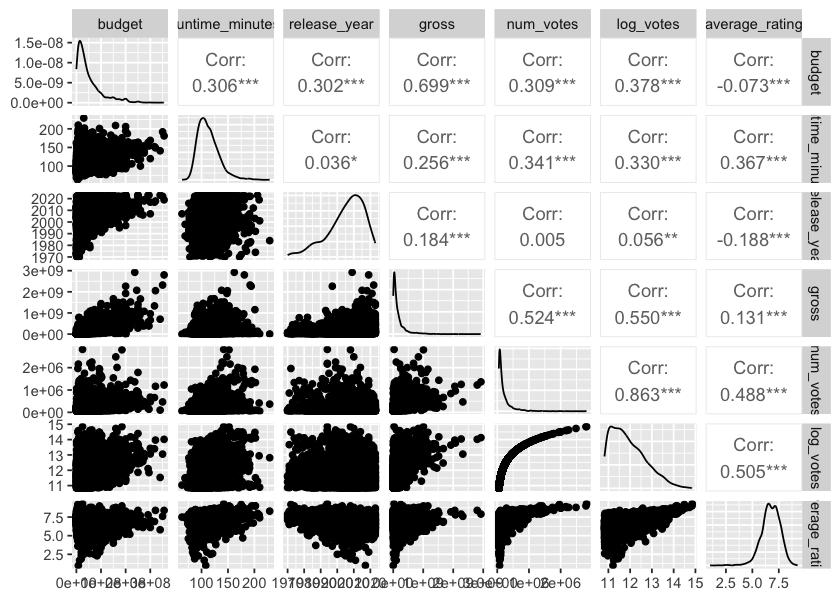

In [28]:
imdb_temp <- imdb_cleaned |>
    dplyr::select(-average_rating, average_rating)

ggpairs(imdb_temp)

The last row in the above grid plots `average_rating` against all the covariates. Some of the covariates seem to have a linear relationship with the response, but in case of others, it is not as clear. Thus, we will now check if taking the `log()` of any of the covariates makes their plot against `average_rating` look more "linear".

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


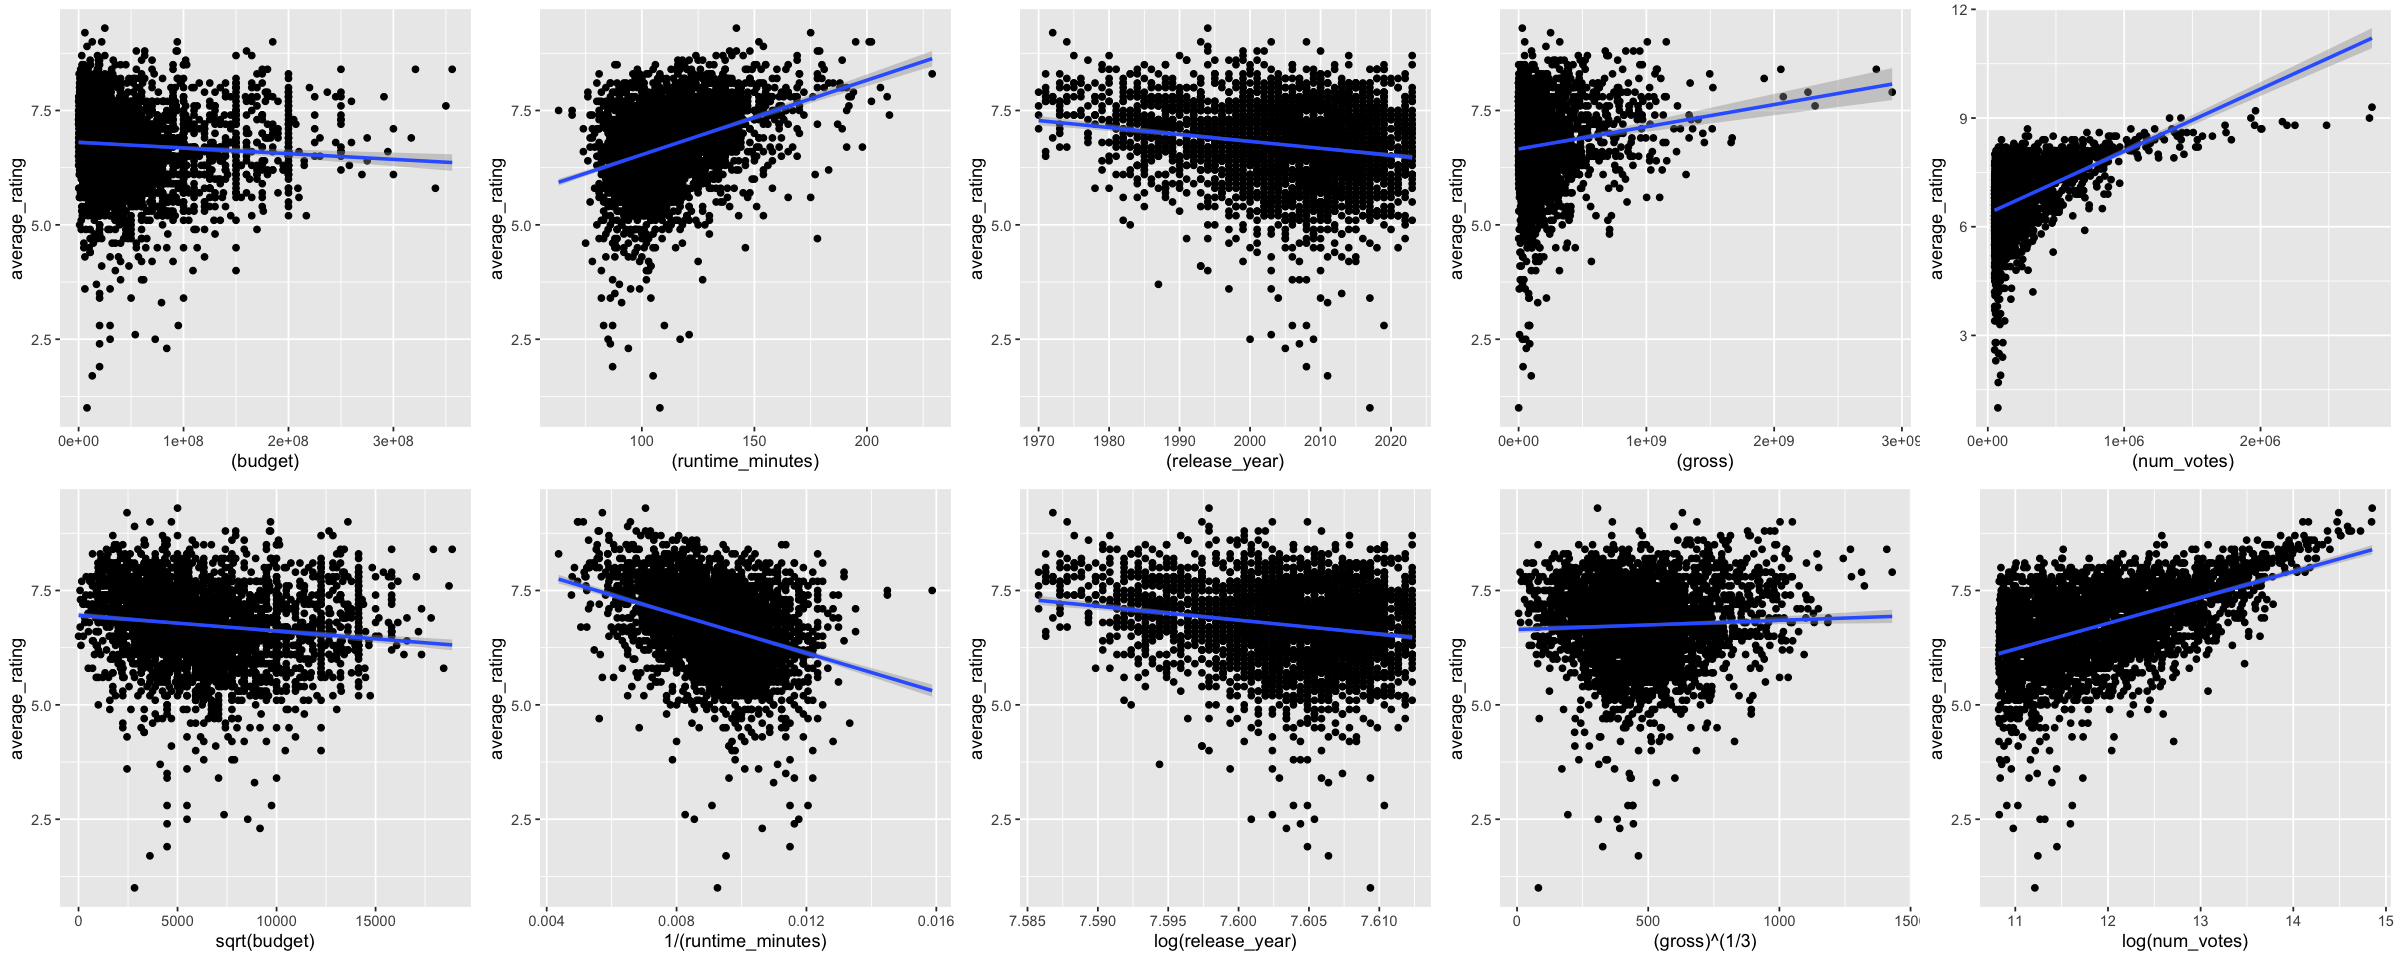

In [46]:
options(repr.plot.width = 20, repr.plot.height = 8)

budget_normal <- imdb_cleaned |>
                ggplot(aes(x = (budget), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

budget_log <- imdb_cleaned |>
                ggplot(aes(x = sqrt(budget), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

runtime_normal <- imdb_cleaned |>
                ggplot(aes(x = (runtime_minutes), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

runtime_log <- imdb_cleaned |>
                ggplot(aes(x = 1/(runtime_minutes), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

release_normal <- imdb_cleaned |>
                ggplot(aes(x = (release_year), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

release_log <- imdb_cleaned |>
                ggplot(aes(x = log(release_year), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")


gross_normal <- imdb_cleaned |>
                ggplot(aes(x = (gross), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

gross_log <- imdb_cleaned |>
                ggplot(aes(x = (gross)^(1/3), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

num_normal <- imdb_cleaned |>
                ggplot(aes(x = (num_votes), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")

num_log <- imdb_cleaned |>
                ggplot(aes(x = log(num_votes), y = average_rating)) +
                geom_point() +
                geom_smooth(method= "lm")


normal_vs_log <- plot_grid(budget_normal, runtime_normal, release_normal, gross_normal, num_normal, 
                           budget_log, runtime_log, release_log, gross_log, num_log, ncol = 5)

normal_vs_log

Upon comparing the above plots, we observe the following:
- the `log()` function seems to serve almost no purpose for the covariates `runtime_minutes` and `release_year`.
- there seem to be significant changes in `log(budget)` and `log(gross)` plots, however, it could be argued that the relationship does not become more "linear".
- the only major difference is visible in `num_votes`, where using `log()` might be beneficial in terms of fitting a model.

Finally, we will be plotting the distribution of the response, to check for any irregularities, such as evident outliers.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


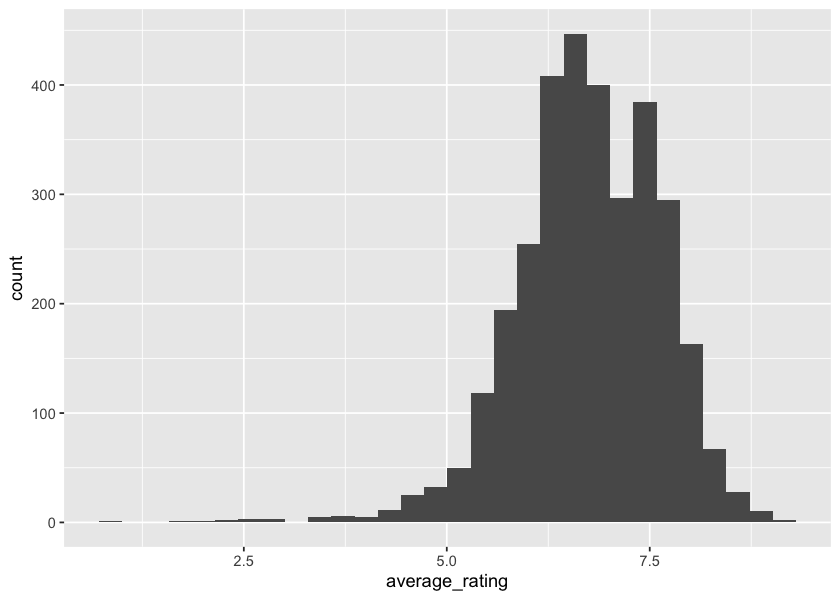

In [47]:
options(repr.plot.width = 7, repr.plot.height = 5)

avg_rating_plot <- imdb_cleaned |>
                ggplot(aes(x = average_rating)) +
                geom_histogram()

avg_rating_plot

# Cleaning

In [ ]:
imdb_cleaned <- imdb_cleaned |> 
  mutate(
    budget = sqrt(budget),                      
    runtime_minutes = 1 /(runtime_minutes),  
    release_year = release_year,                    
    gross = gross^(1/3),                       
    num_votes = log(num_votes)           
  )

#### Leverage (Hat Matrix)

In [ ]:
y <- imdb_cleaned$average_rating
X <- model.matrix(average_rating ~ budget + runtime_minutes + release_year + gross + num_votes, data = imdb_cleaned)

P <- X %*% solve(t(X) %*% X) %*% t(X)

leverage <- diag(P)

n <- nrow(imdb_cleaned)
k <- ncol(X)  # includes intercept
threshold <- 2 * k / n

high_leverage_indices <- which(leverage > threshold)

cat("Leverage threshold:", round(threshold, 4), "\n")
cat("Number of high leverage points:", length(high_leverage_indices), "\n")
cat("Indices of high leverage points:", head(high_leverage_indices), "\n") 

Leverage threshold: 0.0037 
Number of high leverage points: 220 
Indices of high leverage points: 2 3 4 5 6 7 ...


In [ ]:
imdb_cleaned <- imdb_cleaned[-high_leverage_indices, ]
cat("Remaining rows after removing high leverage points:", nrow(imdb_cleaned), "\n")


Remaining rows after removing high leverage points: 2993 


#### Influence (Cooks Distance)

In [ ]:
reg <- lm(average_rating ~ budget + runtime_minutes + release_year + gross + num_votes, data = imdb_cleaned)

X <- model.matrix(reg)
P <- X %*% solve(t(X) %*% X) %*% t(X)
h <- diag(P) 


e <- reg$residuals
sigma2 <- summary(reg)$sigma^2
k <- ncol(X)  

cooks_d <- (e^2 / (k * sigma2)) * (h / (1 - h)^2)

# threshold 
influential_indices <- which(cooks_d > 1)

imdb_cleaned$cooks_distance <- cooks_d
imdb_cleaned$is_influential <- cooks_d > 1

cat("Number of influential observations (Cook's D > 1):", length(influential_indices), "\n")
cat("Indices of influential observations:", head(influential_indices), "...\n")

Number of influential observations (Cook's D > 1): 0 
Indices of influential observations:  ...


#### Outliers

In [54]:
e <- reg$residuals
sigma <- summary(reg)$sigma
X <- model.matrix(reg)
P <- X %*% solve(t(X) %*% X) %*% t(X)
h <- diag(P)  # leverage

standardized_residuals <- e / (sigma * sqrt(1 - h))
outlier_indices <- which(abs(standardized_residuals) > 3)
imdb_cleaned <- imdb_cleaned[-outlier_indices, ]
cat("Removed", length(outlier_indices), "outlier(s) with |standardized residual| > 3\n")

Removed 31 outlier(s) with |standardized residual| > 3


## Model Selection and Diagnostics

### Multicollinearity

In [55]:
imdb_cleaned <- imdb_cleaned |> mutate(log_votes = log(num_votes))

In [56]:
reg_budget <- lm(budget ~ log_votes + release_year + runtime_minutes + gross, data = imdb_cleaned)
VIF_budget <- 1 / (1 - summary(reg_budget)$r.squared)
print(paste("VIF(budget):", round(VIF_budget, 3)))

reg_votes <- lm(log_votes ~ budget + release_year + runtime_minutes + gross, data = imdb_cleaned)
VIF_votes <- 1 / (1 - summary(reg_votes)$r.squared)
print(paste("VIF(num_votes):", round(VIF_votes, 3)))

reg_year <- lm(release_year ~ budget + log_votes + runtime_minutes + gross, data = imdb_cleaned)
VIF_year <- 1 / (1 - summary(reg_year)$r.squared)
print(paste("VIF(release_year):", round(VIF_year, 3)))

reg_runtime <- lm(runtime_minutes ~ budget + log_votes + release_year + gross, data = imdb_cleaned)
VIF_runtime <- 1 / (1 - summary(reg_runtime)$r.squared)
print(paste("VIF(runtime_minutes):", round(VIF_runtime, 3)))

reg_gross <- lm(gross ~ budget + log_votes + release_year + runtime_minutes, data = imdb_cleaned) 
VIF_gross <- 1 / (1 - summary(reg_gross)$r.squared)
print(paste("VIF(gross):", round(VIF_gross, 3)))


[1] "VIF(budget): 2.595"
[1] "VIF(num_votes): 1.745"
[1] "VIF(release_year): 1.078"
[1] "VIF(runtime_minutes): 1.192"
[1] "VIF(gross): 3.225"


### Forward Selection

In [57]:
forward_model <- regsubsets(x = average_rating ~ release_year + budget + log_votes + runtime_minutes + gross,
                            nvmax = 5, 
                            data = imdb_cleaned,
                            method = "forward")

In [58]:
summary_forward <- summary(forward_model)
summary_forward

Subset selection object
Call: regsubsets.formula(x = average_rating ~ release_year + budget + 
    log_votes + runtime_minutes + gross, nvmax = 5, data = imdb_cleaned, 
    method = "forward")
5 Variables  (and intercept)
                Forced in Forced out
release_year        FALSE      FALSE
budget              FALSE      FALSE
log_votes           FALSE      FALSE
runtime_minutes     FALSE      FALSE
gross               FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: forward
         release_year budget log_votes runtime_minutes gross
1  ( 1 ) " "          " "    "*"       " "             " "  
2  ( 1 ) " "          "*"    "*"       " "             " "  
3  ( 1 ) " "          "*"    "*"       "*"             " "  
4  ( 1 ) "*"          "*"    "*"       "*"             " "  
5  ( 1 ) "*"          "*"    "*"       "*"             "*"  

#### Adjusted $R^2$ and AIC Comparison

In [59]:
# Create empty vectors
adj_r2_vals <- numeric(5)
aic_vals <- numeric(5)

# Loop over 1 to 5 variables
for (i in 1:5) {
  # Get the variable names (excluding intercept)
  vars <- names(coef(forward_model, id = i))[-1]
  
  # Build a formula
  formula_i <- as.formula(paste("average_rating ~", paste(vars, collapse = " + ")))
  
  # Fit the model
  model_i <- lm(formula_i, data = imdb_cleaned)
  
  # Store Adjusted R² and AIC
  adj_r2_vals[i] <- summary(model_i)$adj.r.squared
  aic_vals[i] <- AIC(model_i)
}

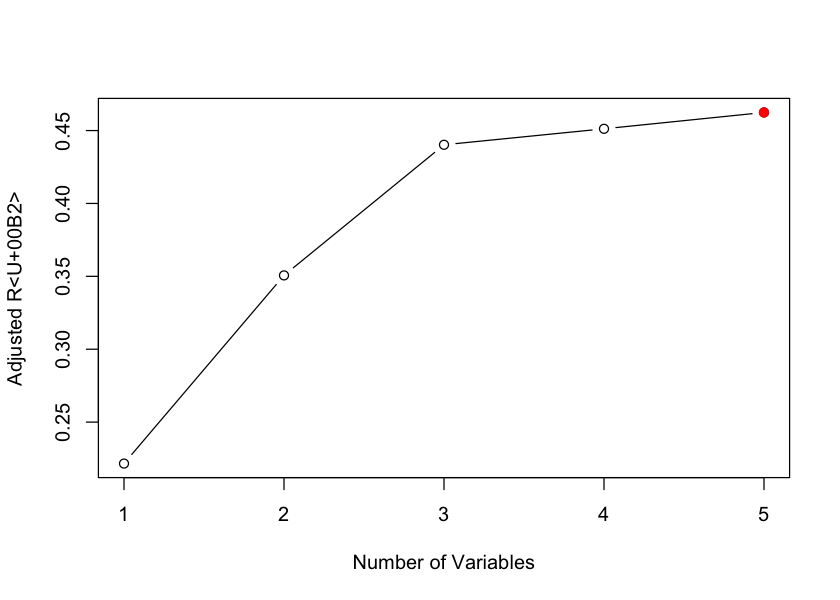

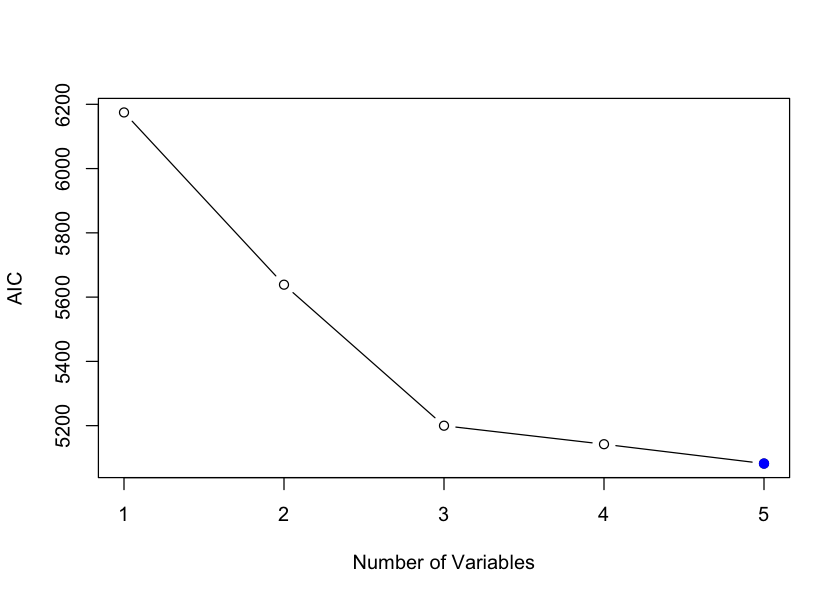

In [60]:
# Plot adjusted R²
plot(adj_r2_vals, xlab = "Number of Variables", ylab = "Adjusted R²", type = "b")
points(which.max(adj_r2_vals), max(adj_r2_vals), col = "red", pch = 19)

# Plot AIC
plot(aic_vals, xlab = "Number of Variables", ylab = "AIC", type = "b")
points(which.min(aic_vals), min(aic_vals), col = "blue", pch = 19)

### Final Model

In [61]:
# By Principle of Parsimony, we should go with the model with 4 covariates
model <- lm(average_rating ~ release_year + budget + log_votes + runtime_minutes, data = imdb_cleaned)

### Diagnostics

#### Residuals vs Fitted Values For Heteroscedasticity

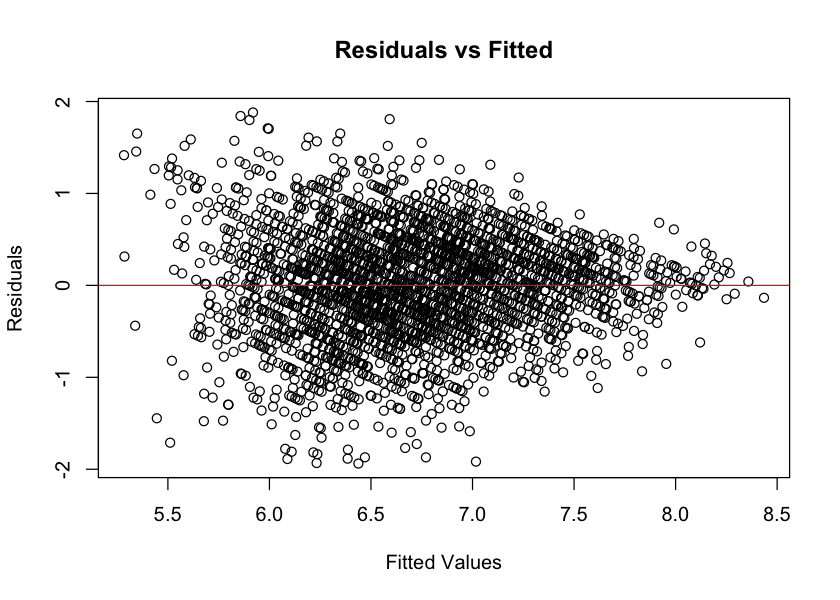

In [62]:
plot(model$fitted.values, resid(model),
     xlab = "Fitted Values", ylab = "Residuals",
     main = "Residuals vs Fitted")
abline(h = 0, col = "red")

#### QQ-Plot For Normality Assumption

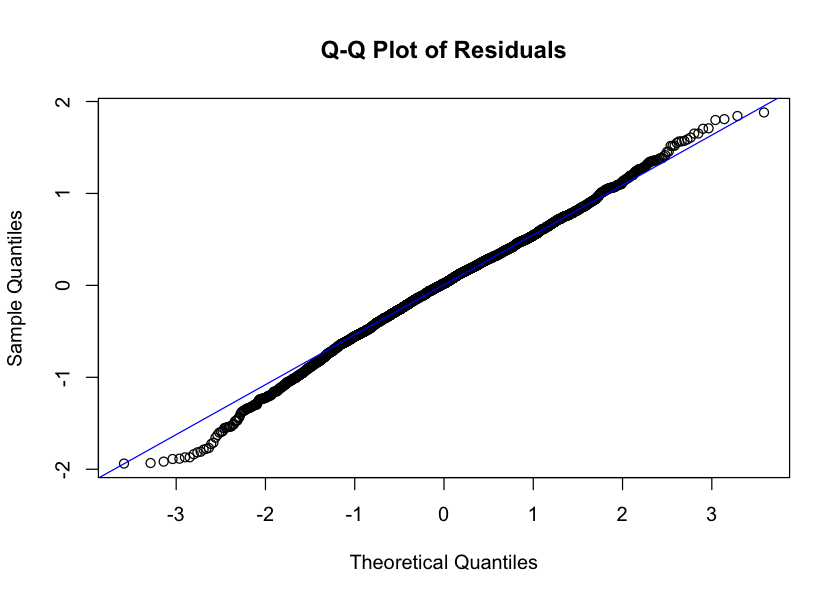

In [63]:
qqnorm(resid(model), main = "Q-Q Plot of Residuals")
qqline(resid(model), col = "blue")

#### Standardized residuals to check for outliers

In [64]:
std_resid <- rstandard(model)

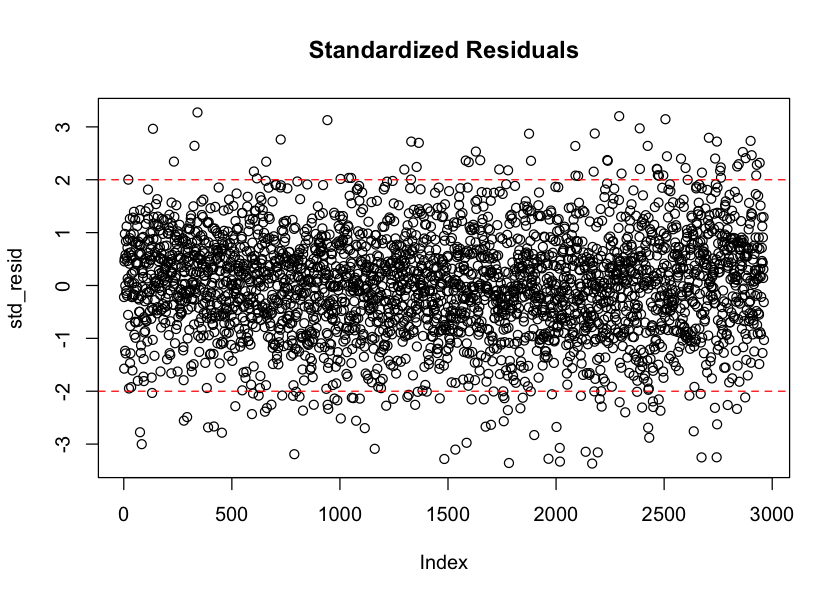

In [65]:
plot(std_resid, main = "Standardized Residuals")
abline(h = c(-2, 2), col = "red", lty = 2)

We examined standardized residuals to identify potential outliers. Most observations fell within the ±2 range, with a few values slightly exceeding these thresholds. Although some outliers exist, their frequency and distance from the bulk of residuals do not appear to meaningfully distort the model, especially given the large sample size.